<a href="https://colab.research.google.com/github/mdogruer905/Boston-House-Price-With-Keras/blob/main/Boston_House_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Boston Gayrimenkul Fiyatları Veri Seti**
Bölgesel vergi oranı, suç oranı vb. verilere bakarak 1970 ortalarında Boston Banliyösünde ki ev fiyatları tahmin edilmeye çalışılacaktır

> Veride ki öznitelikler **Suç oranı** örnek olarak farklı niteliklere sahiptir. Bazıları 0 ile 1 arasında değer alırken bazıları 1 ile 12 arasında değer, bazıları ise 0 ile 100 arasında değer değer almaktadır

In [1]:
from google.colab import drive
drive.mount('/gdrive')
% cd/gdrive

Mounted at /gdrive
/gdrive


In [2]:
#Device info
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3760108307934506722, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3730008716717134714
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_target) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

# Preprocessing Normalize

Her sütundan o sütunun ortalamasını çıkarıp standart sapmasına bölme işlemi yapıyoruz. Böylece nitelik 0 civarında ortalanır ve birim standart sapmaya sahiptir.

In [6]:
mean = train_data.mean(axis=0) # Train veri setini sütun bazında ortalama
train_data -=mean 
std = train_data.std(axis=0)
train_data /=std 

In [10]:
test_data -= mean
test_data /= std

# Bulding Network

In [24]:
from keras import models
from keras import layers

# Creating Function for Network

model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])

# **K-Fold Doğrulama**
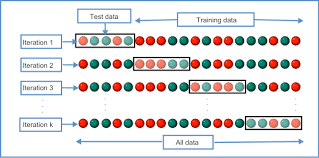

In [26]:
import numpy as np
k = 4
num_val_sample = len(train_data)// k
num_epochs = 50
all_scores = []

for i in range(k):
  print('Processing fold #',i)
  # K sayısncı parçada ki doğrulama verisini hazırlar
  val_data = train_data[i * num_val_sample:(i + 1) * num_val_sample]
  val_target = train_targets[i * num_val_sample: (i + 1) * num_val_sample]
  # Eğitim veri setini hazırlar: Veriler diğer parçalardan gelir
  partial_train_data = np.concatenate([train_data[:i * num_val_sample], train_data[(i + 1)* num_val_sample:]],axis=0)
  partial_targets_data = np.concatenate([train_targets[:i * num_val_sample],train_targets[(i + 1) * num_val_sample:]],axis=0)
  model.fit(partial_train_data, partial_targets_data, epochs=num_epochs, batch_size=1,verbose=0)
  val_mse, val_mae = model.evaluate(val_data,val_target,verbose=0)
  all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


# Her Parçada Doğrulama Günlüğü Kaydetmek

In [35]:
import tensorflow as tf

In [39]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [40]:
num_epochs1 = 250
all_mae_histories = []
for i in range(k):
  print('processing fold #',i)

  val_data = train_data[i * num_val_sample:(i + 1) * num_val_sample]
  val_target = train_targets[i * num_val_sample: (i + 1) * num_val_sample]
  # Eğitim veri setini hazırlar: Veriler diğer parçalardan gelir
  partial_train_data = np.concatenate([train_data[:i * num_val_sample], train_data[(i + 1)* num_val_sample:]],axis=0)
  partial_targets_data = np.concatenate([train_targets[:i * num_val_sample],train_targets[(i + 1) * num_val_sample:]],axis=0)
  history = model.fit(partial_train_data,partial_targets_data,validation_data=(val_data,val_target),epochs=num_epochs1,batch_size=1,verbose=0)
  mae_history = history.history['mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [41]:
#k-fold doğrulama skorların ortalamasını alma işlemi
average_mae_history = [
                       np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

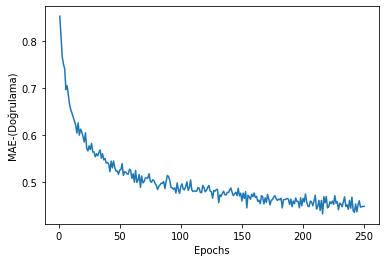

In [43]:
#Doğrulama skorları gösterimi
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MAE-(Doğrulama)')
plt.show()

# **Modeli Son Olarak Eğitelim**

In [45]:
model.fit(train_data,train_targets, epochs=80,batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_target)

4/4 [==============================] - 0s 4ms/step - loss: 11.9978 - mae: 2.5786


In [54]:
print("Modelin Gerçek Fiyatlardan Tahmin Edilen Uzaklığı {0:.3f}".format(test_mae_score))# Dolar türünden düşünülmelidir

Modelin Gerçek Fiyatlardan Tahmin Edilen Uzaklığı 2.579


# **Sonuçlar ve Yorumlama**
> Gerçek fiyatlardan 2550 $ daha uzakta bir tahmin yapmış demekteyiz

Çok az veri varken K-fold çapraz doğrulama kullanmak modeli değerlendirmek için çok güvenli bir yoldur.
Çok az veri varken bir **hidden layer size** 'gizli katman' bir veya iki tane kullanmak küçük modeller için **overfitting** 'aşırı uydurma' önüne geçer